In [1]:
import cell2fate as c2f
import scanpy as sc
import numpy as np
import os
import matplotlib.pyplot as plt
data_name = 'MouseBoneMarrow'

Global seed set to 0


In [2]:
# Where to get data from and where to save results (you need to modify this)
data_path = '/nfs/team283/aa16/data/fate_benchmarking/benchmarking_datasets/MouseBoneMarrow/'
results_path = '/nfs/team283/aa16/cell2fate_paper_results/MouseBoneMarrow/'

In [3]:
# Downloading data into specified directory:
os.system('cd ' + data_path + ' && wget -q https://cell2fate.cog.sanger.ac.uk/' + data_name + '/' + data_name + '_anndata.h5ad')

0

Load the data and extract most variable genes (and optionally remove some clusters).

In [4]:
adata = sc.read_h5ad(data_path + data_name + '_anndata.h5ad')
clusters_to_remove = []
adata = c2f.utils.get_training_data(adata, cells_per_cluster = 10**5, cluster_column = 'clusters',
                                    remove_clusters = clusters_to_remove,
                                min_shared_counts = 20, n_var_genes= 3000)

Keeping at most 100000 cells per cluster
Filtered out 20300 genes that are detected 20 counts (shared).
Skip filtering by dispersion since number of variables are less than `n_top_genes`.


In [5]:
max_modules = c2f.utils.get_max_modules(adata)

Leiden clustering ...


2023-07-20 17:19:35.890515: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /software/gcc-8.2.0/lib64/
2023-07-20 17:19:35.891018: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /software/gcc-8.2.0/lib64/
2023-07-20 17:19:35.891040: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


Number of Leiden Clusters: 8
Maximal Number of Modules: 9


Overview of the dataset on a UMAP, coloured by cluster assingment.

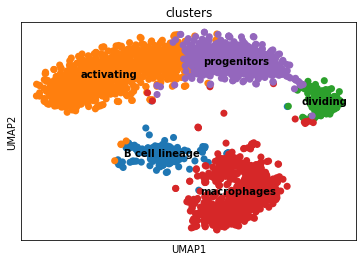

In [6]:
fig, ax = plt.subplots(1,1, figsize = (6, 4))
sc.pl.umap(adata, color = ['clusters'], s = 200, legend_loc='on data', show = False, ax = ax)
plt.savefig(results_path + data_name + 'UMAP_clusters.pdf')

As usual in the scvi-tools workflow we register the anndata object ...

In [7]:
c2f.Cell2fate_DynamicalModel.setup_anndata(adata, spliced_label='spliced', unspliced_label='unspliced')

... and initialize the model:

In [8]:
mod = c2f.Cell2fate_DynamicalModel(adata, n_modules = max_modules)

Let's have a look at the anndata setup:

In [9]:
mod.view_anndata_setup()

Anndata setup with scvi-tools version 0.16.1.

Setup via `Cell2fate_DynamicalModel.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': None,
│   'labels_key': None,
│   'unspliced_label': 'unspliced',
│   'spliced_label': 'spliced',
│   'cluster_label': None
}

     Summary Statistics     
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Summary Stat Key ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│     n_cells      │ 2600  │
│      n_vars      │ 1252  │
│     n_batch      │   1   │
└──────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  unspliced   │ adata.layers['unspliced'] │
│   spliced    │  adata.layers['spliced']  │
│    batch     │ adata.obs['_scvi_batch']  │
│    ind_x     │   adata.obs['_indices']   │
└──────────────┴───────────────────────────┘

                     batch State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_batch'] │     0      │          0          │
└──────────────────────────┴────────────┴─────────────────────┘

Training the model:

In [10]:
mod.train()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 500/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [05:08<00:00,  1.62it/s, v_num=1, elbo_train=2.83e+6]


We plot training history over multiple windows to effectively assess convergence (which is not reached here but it is close.)

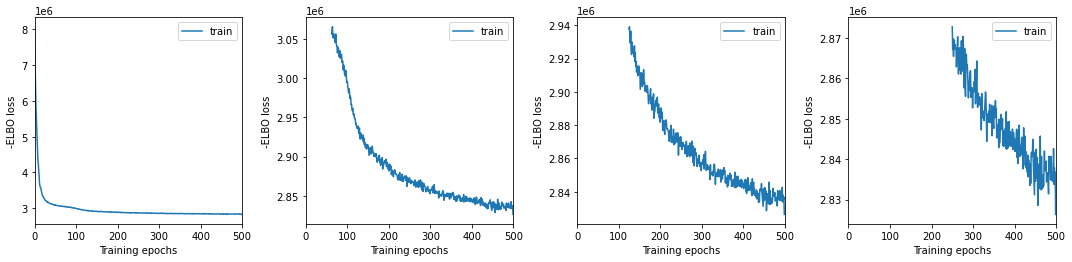

In [11]:
mod.view_history()

Here we export the model posterior to the anndata object:

In [12]:
adata = mod.export_posterior(adata)

sample_kwargs['batch_size'] 2600
Sampling global variables, sample: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  7.76it/s]


One of the interesting parameter posteriors that was saved to the anndata object is the differentiation time:

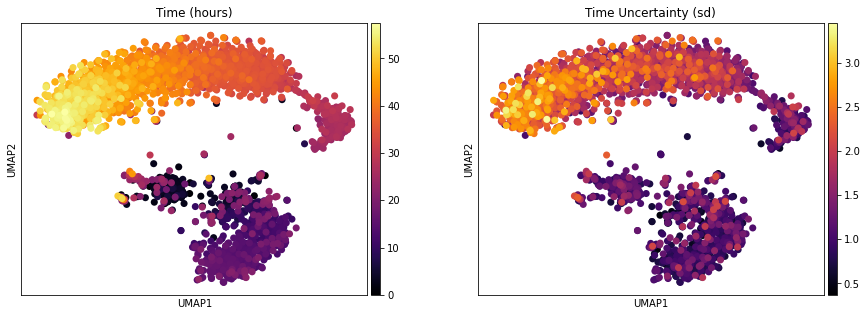

In [13]:
fig, ax = plt.subplots(1,2, figsize = (15, 5))
sc.pl.umap(adata, color = ['Time (hours)'], legend_loc = 'right margin',
                size = 200, color_map = 'inferno', ncols = 2, show = False, ax = ax[0])
sc.pl.umap(adata, color = ['Time Uncertainty (sd)'], legend_loc = 'right margin',
                size = 200, color_map = 'inferno', ncols = 2, show = False, ax = ax[1])
plt.savefig(results_path + data_name + 'UMAP_Time.pdf')

We can compute some module statistics to visualize the activity of the underlying modules:

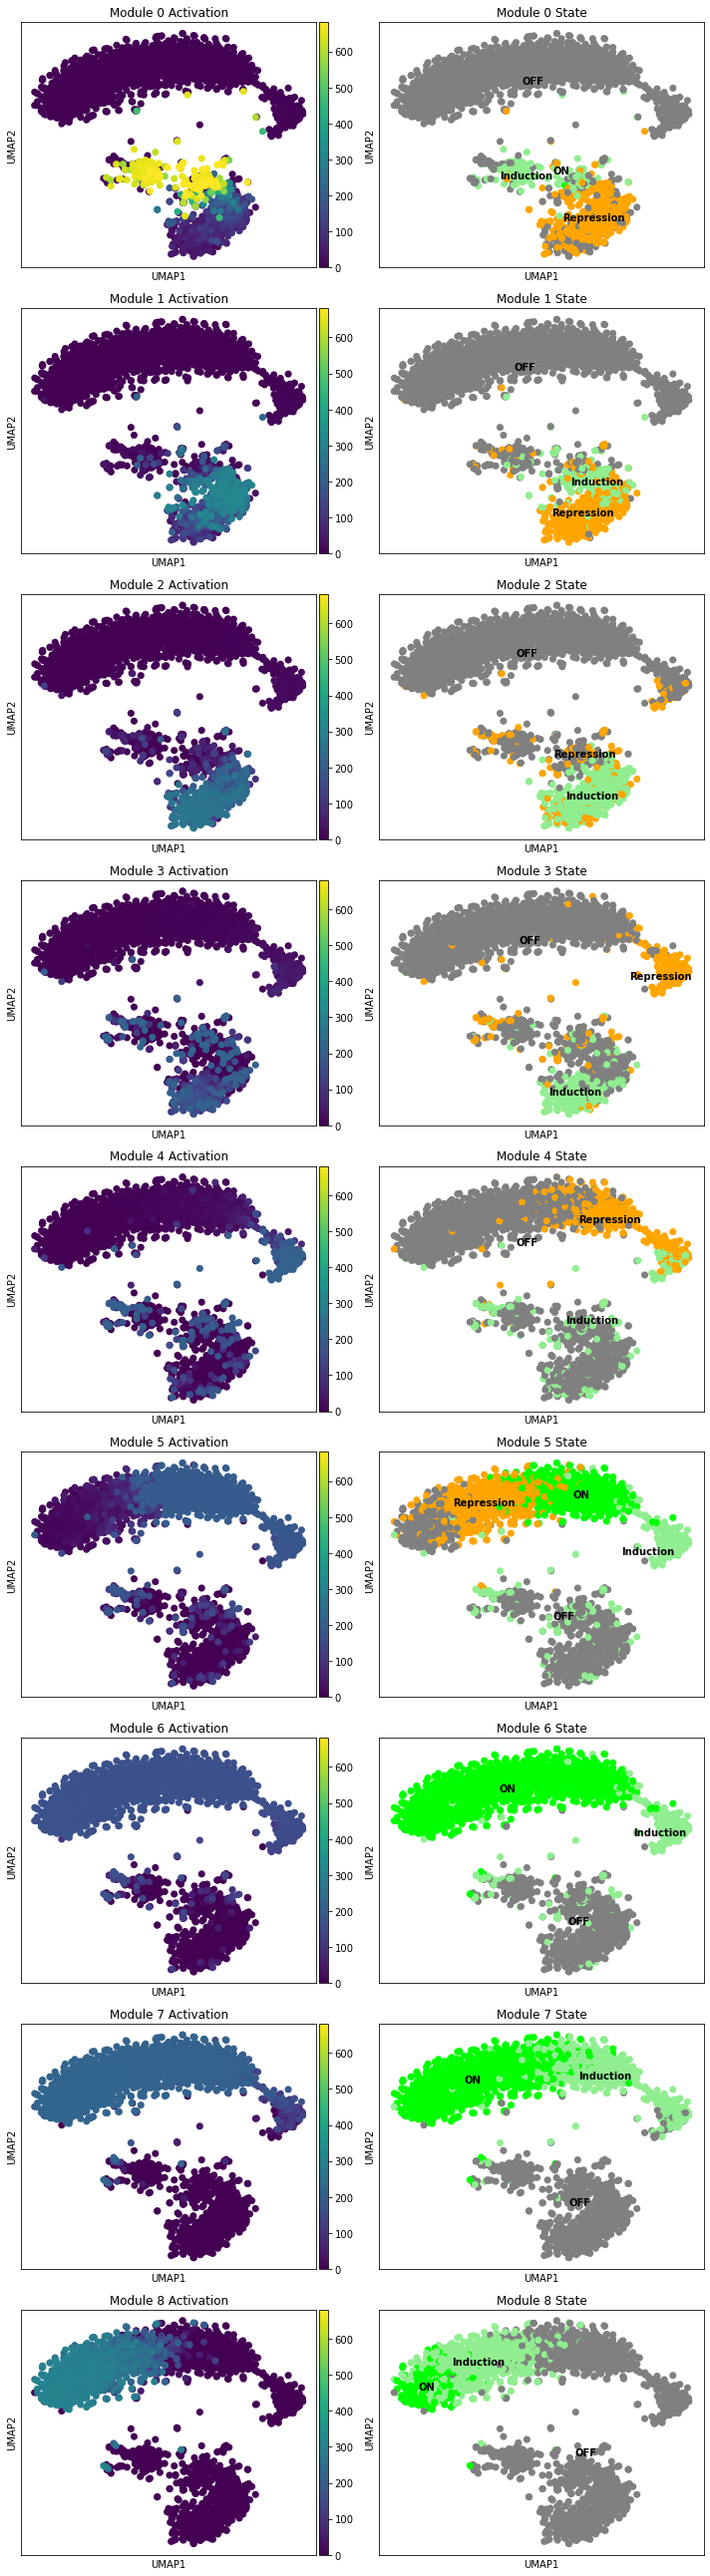

In [14]:
adata = mod.compute_module_summary_statistics(adata)
mod.plot_module_summary_statistics(adata, save = results_path + data_name + 'module_summary_stats_plot.pdf')

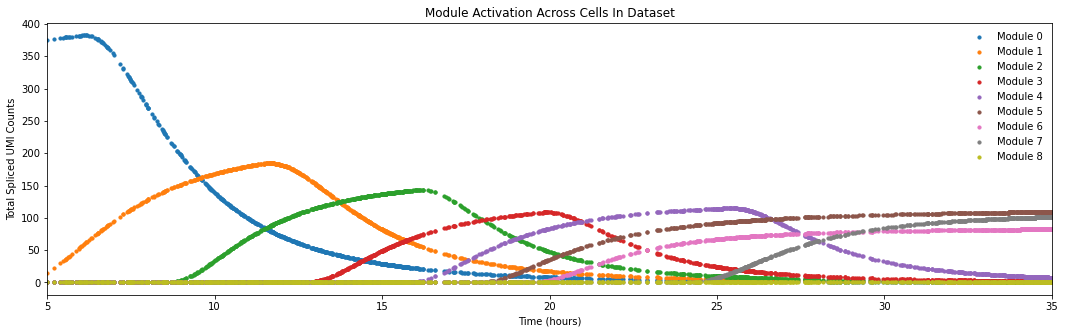

In [15]:
mod.compare_module_activation(adata, chosen_modules = [0,1,2,3,4,5,6,7,8], time_max = 35, time_min = 5,
                         save = results_path + data_name + 'module_activation_comparison.pdf')

It is also possible to visualize "module-specific" velocity although this does not always work well:

In [16]:
# mod.compute_and_plot_module_velocity(adata, save = results_path + data_name + 'module_velocity_plots.png')

And of course we can make the usual visualization of total RNAvelocity on a UMAP:

Computing total RNAvelocity ...


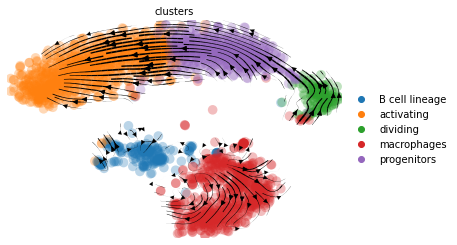

In [17]:
mod.compute_and_plot_total_velocity(adata, save = results_path + data_name + 'total_velocity_plots.png')

To make the plot look the same in style as the scvleo plots:

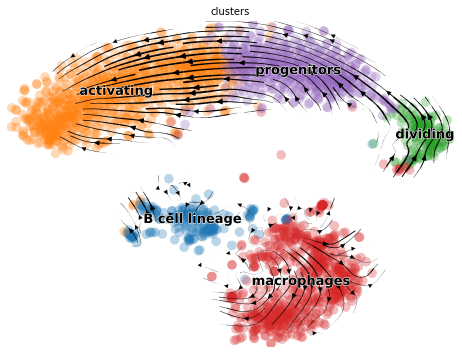

In [18]:
import scvelo as scv
fix, ax = plt.subplots(1, 1, figsize = (8, 6))
scv.pl.velocity_embedding_stream(adata, basis='umap', save = False, vkey='Velocity',
                                 show = False, ax = ax, legend_fontsize = 13)
plt.savefig(results_path + data_name + 'total_velocity_plots.png')

Technical variables usually show lower detection efficiency and higher noise (= lower overdispersion parameter) for unspliced counts:

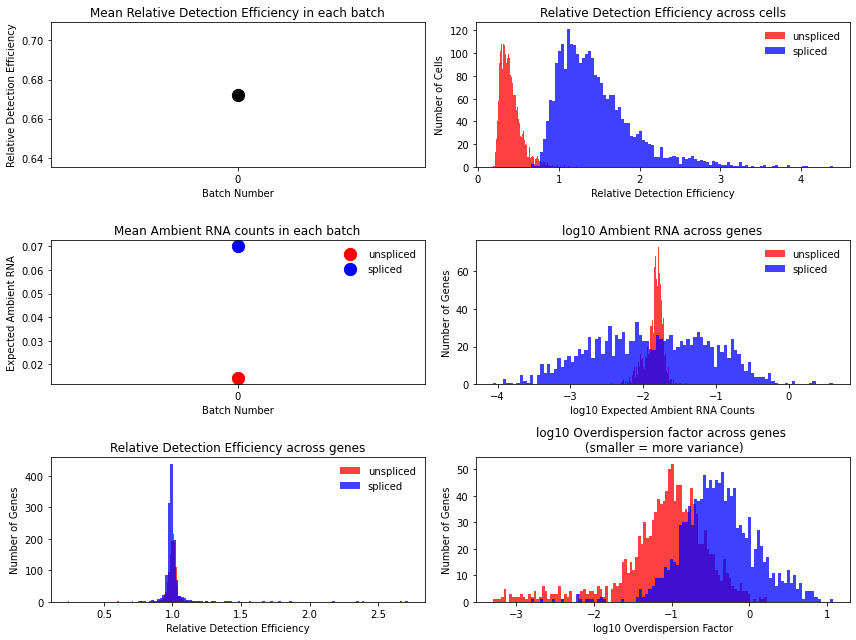

In [19]:
mod.plot_technical_variables(adata, save = results_path + data_name + 'technical_variables_overview_plot.pdf')

This is how to have a look at the various rate parameters the optimization converged to:

In [20]:
print('A_mgON mean:', np.mean(mod.samples['post_sample_means']['A_mgON']))
print('gamma_g mean:', np.mean(mod.samples['post_sample_means']['gamma_g']))
print('beta_g mean:', np.mean(mod.samples['post_sample_means']['beta_g']))
print('lam_mi, all modules: \n \n', np.round(mod.samples['post_sample_means']['lam_mi'],2))

A_mgON mean: 0.07635634
gamma_g mean: 0.9589631
beta_g mean: 0.86195856
lam_mi, all modules: 
 
 [[[2.99 2.42]]

 [[1.49 1.71]]

 [[3.   3.02]]

 [[3.08 3.45]]

 [[3.15 2.79]]

 [[3.33 2.57]]

 [[3.84 3.65]]

 [[1.55 2.27]]

 [[3.55 2.71]]]


This method returns orders the genes and TFs in each module from most to least enriched. And it also performs gene set enrichment analysis:

In [21]:
tab, all_results = mod.get_module_top_features(adata, p_adj_cutoff=0.01, background = adata.var_names)
tab.to_csv(results_path + data_name + 'module_top_features_table.csv')
tab

,Module Number,Genes Ranked,TFs Ranked,Terms Ranked
0,0,"Car2, Igll1, Aff3, Lef1, Rnf220, Lgals9, Ptprc...","Aff3, Lef1, Ebf1, Pou2af1, Bach2, Mef2c, Myb, ...",B cell receptor signaling pathway (GO:0050853)
1,1,"Anxa6, Lgals1, Irf8, Txndc5, Ctsb, Rac1, Col11...","Irf8, E2f8, Stat5b, Trps1, Bcl11a, Bclaf1, Zeb...","neutrophil degranulation (GO:0043312), neutrop..."
2,2,"Vcan, Pid1, Fn1, S100a4, Ctss, Clec7a, F13a1, ...","Nr4a2, Trps1, Jarid2, Zeb2, Fosl2, Nr4a3, Klf3...",regulation of cytokine-mediated signaling path...
3,3,"Il6, Gata2, Ccl4, Tnfaip3, Cpa3, Flnb, Sirpb1b...","Gata2, Tcf4, Foxp1, Zcchc6, Ikzf2, Nfkbiz, Mef...",angiogenesis involved in wound healing (GO:006...
4,4,"Fcnb, Cdca8, Nusap1, Cenpe, Neil3, Smc2, Mki67...","E2f8, Ctcf, Smarcc1, Bach2, Ebf1, Pou2af1, Ezh...",mitotic sister chromatid segregation (GO:00000...
5,5,"Zmpste24, Ica1, Fmnl2, Serpinb1a, Gca, Cpne3, ...","Erg, Mbnl3, Ncoa4, Arid5b, Arid2, Ets1, Ikzf1,...","neutrophil degranulation (GO:0043312), neutrop..."
6,6,"Agap1, Ogfrl1, Slc40a1, Gpi1, Ccno, Stim1, Sun...","Lrrfip2, Jdp2, Kdm5a, Tsc22d4, Mxi1, Stat1, At...","nucleus localization (GO:0051647), nuclear mig..."
7,7,"Tcp11l2, Fpr2, Plbd1, Zfhx3, Rnf10, Scrg1, Trp...","Zfhx3, Sp140, Scaper, Rlf, Nfkbiz, Klf7, Mxi1,...","neutrophil degranulation (GO:0043312), neutrop..."
8,8,"Cxcl2, Basp1, Stfa3, Clec4d, Bst1, Cd101, Cxcr...","Fosl2, Klf3, Mxd1, Plek, Preb, Max, Zfyve26, B...",


Reprocessing adata.X, set process = False if this is not desired.


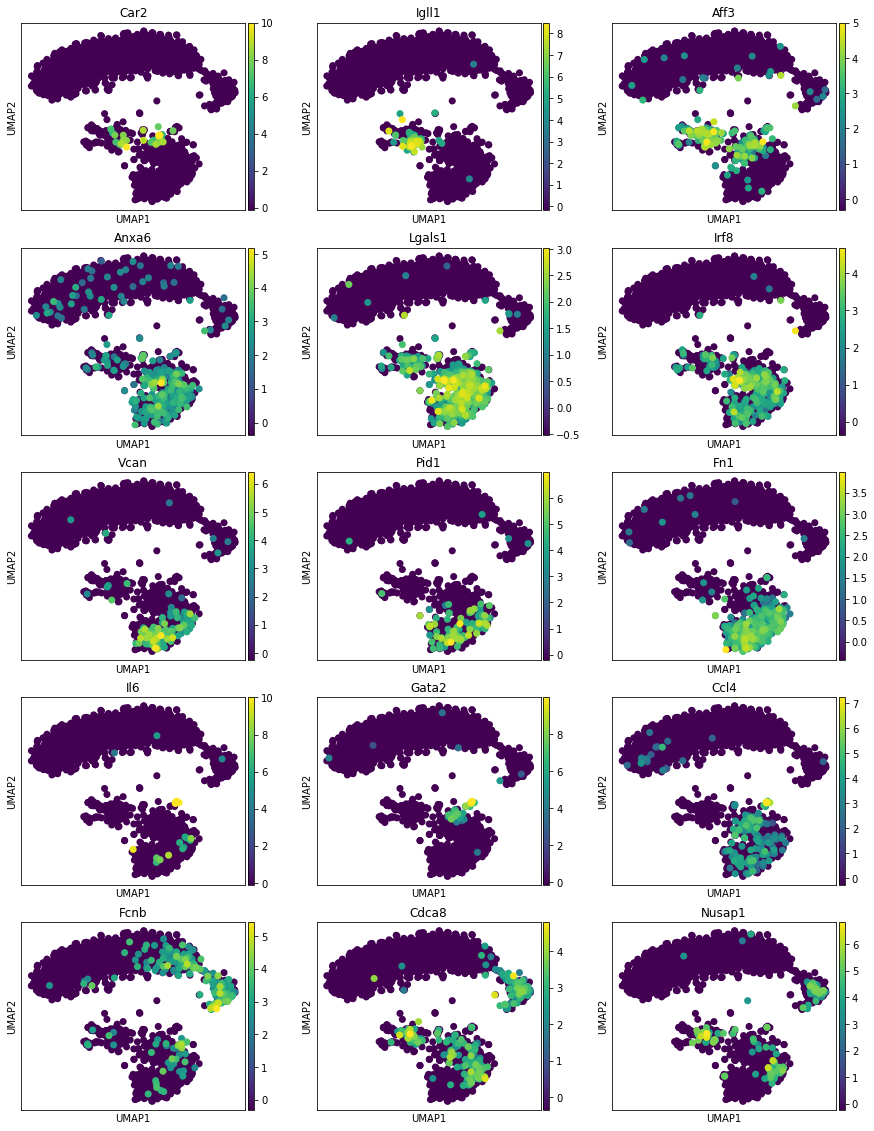

In [22]:
mod.plot_top_features(adata, tab, chosen_modules = [0,1,2,3,4], mode = 'all genes', n_top_features = 3, process = True)